# Transfer Learning

This notebook shows how to apply transfer learning on image datasets

### Import all the needed modules

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

sns.set()

### Define paths for the data location and the place to save the model

Unfortunately the data used here is a private data. However it can be replaced by any healthy/unhealthy classification problem as long as the folder structure is followed.

*   training
    *   healthy
    *   unhealthy    
*   test    
    *   healthy
    *   unhealthy

In [2]:
TRAIN_DIR = '~/datasets/rice/train/'
TEST_DIR = '~/datasets/rice/test/'
CKPT_DIR='vgg_16_ckpts_{epoch:03d}.ckpt'
BEST_DIR='vgg_16_best.ckpt'

### Load the images and add augmentations

The training/validation set has multiple random data transformations while the training set is just scaled for the sake of normalization

In [3]:
train_idg = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=360,
    zoom_range=0.5,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    rescale=1.0/255
)
test_idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

class_mode = 'binary'
classes = {
    'healthy': 0,
    'unhealthy': 1,
}

train_gen = train_idg.flow_from_directory(TRAIN_DIR, (224, 224),
                                          seed=0,
                                          batch_size=128,
                                          subset='training',
                                          class_mode=class_mode,
                                          classes=classes)

valid_gen = train_idg.flow_from_directory(TRAIN_DIR, (224, 224),
                                          seed=0,
                                          batch_size=128,
                                          subset='validation',
                                          class_mode=class_mode,    
                                          classes=classes)

test_gen = test_idg.flow_from_directory(TEST_DIR, (224, 224),
                                        class_mode=class_mode,
                                        classes=classes,
                                        shuffle=False,
                                        batch_size=1)

Found 36 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


### Create a base model and add additional layers

Load the keras VGG model without the last/top layers and add the needed layers to solve the classification problem. Also some of the initial layers of the VGG model are set to be not trainable since only fine tuning is done to the model

In [4]:
img_input = tf.keras.layers.Input((224, 224, 3))
base_model = tf.keras.applications.VGG16(include_top=False,
                   weights='imagenet',
                   input_tensor=img_input)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=img_input, outputs=predictions)

for layer in base_model.layers[:-4]:
    layer.trainable = False
    
model.compile('adam', 'binary_crossentropy')

### Train the Keras model

Different callbacks are also added save the model and regularize training

In [5]:
es = tf.keras.callbacks.EarlyStopping(patience=20)
mc = tf.keras.callbacks.ModelCheckpoint(CKPT_DIR)
bm = tf.keras.callbacks.ModelCheckpoint(BEST_DIR, save_best_only=True)
hst = model.fit(
    train_gen,
    steps_per_epoch=1,
    epochs=10,
    callbacks=[es, mc, bm],
    validation_data=valid_gen,
    validation_steps=1,
    max_queue_size=1
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: vgg_16_ckpts_001.ckpt\assets
INFO:tensorflow:Assets written to: vgg_16_best.ckpt\assets
1/1 [==============================] - 15s 15s/step - loss: 0.6876 - val_loss: 1.4342
Epoch 2/10
INFO:tensorflow:Assets written to: vgg_16_ckpts_002.ckpt\assets
INFO:tensorflow:Assets written to: vgg_16_best.ckpt\assets
1/1 [==============================] - 14s 14s/step - loss: 1.5226 - val_loss: 1.0496
Epoch 3/10
INFO:tensorflow:Assets written to: vgg_16_ckpts_003.ckpt\assets
INFO:tensorflow:Assets written to: vgg_16_best.ckpt\assets
1/1 [==============================] - 14s 14s/step - loss: 1.2616 - val_loss: 0.6851
Epoch 4/10
INFO:tensorflow:Assets written to: vgg_16_ckpts_004.ckpt\assets
1/1 [==============================] - 12s 12s/step - loss: 0.6923 - val_loss: 0.7016
Epoch 5/

### Load the training data from the python generators

Since the keras utilities create generators, they should be called to create the data

In [6]:
test_data = [next(test_gen) for _ in range(test_gen.n)]
test_data = list(zip(*test_data))
test_X, test_y = test_data
test_X = np.concatenate(test_X, axis=0)
test_y = np.concatenate(test_y, axis=0)

### Predict the result using the best model

In [7]:
test_y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.], dtype=float32)

In [8]:
best_model = tf.keras.models.load_model(BEST_DIR)
test_y_pred = best_model.predict(test_X)

In [9]:
roc_auc_score(test_y, test_y_pred)

0.9917355371900827

In [10]:
accuracy_score(test_y > 0.5, test_y_pred > 0.5)

0.7727272727272727

In [11]:
print(classification_report(test_y > 0.5, test_y_pred > 0.5))

              precision    recall  f1-score   support

       False       0.69      1.00      0.81        11
        True       1.00      0.55      0.71        11

    accuracy                           0.77        22
   macro avg       0.84      0.77      0.76        22
weighted avg       0.84      0.77      0.76        22



In [12]:
confusion_matrix(test_y > 0.5, test_y_pred > 0.5)[1, 0]

5

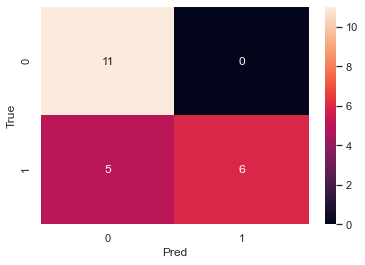

In [13]:
sns.heatmap(confusion_matrix(test_y > 0.5, test_y_pred > 0.5), annot=True)
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()